## Modeling

**Instructions from Springboard**
* Here comes the really fun step: modeling! For this step, you'll consider the types of models that would be appropriate to use given the features in your dataset and then dive right in and build two or three models. Please note: in addition to considering different algorithm types in your model selection, be sure to also consider applying model hyperparameter tuning operations. 


**Modeling Approach**
* Use AUC as the metric to evaluate on subset of features (~40 features with one hot encoding)
    * Start with logistic regression, change regularization parameter
    * Try random forest
    * Gradient boosting
    
    
**Error Analysis**
* Use random forest and check for under/overfitting

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import Preprocessing as data

import warnings
warnings.simplefilter("ignore") #Copy set on slice warning, ignore

importing Jupyter notebook from Preprocessing.ipynb
importing Jupyter notebook from Data_Cleanup.ipynb
/Users/maureenkeenan/Desktop/Kaggle/WiDs_Datathon_2020


/Users/maureenkeenan/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/maureenkeenan/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [2]:
Xtest = data.Xtest
Xtrain = data.Xtrain
ytest = data.ytest
ytrain = data.ytrain

features = data.features

#### Start with a logistic regression

In [3]:
from sklearn.linear_model import LogisticRegressionCV

#Main tuning for LogReg is C (regularization) and error
logreg = LogisticRegressionCV(cv=5, Cs=[.000000001])
logreg.fit(Xtrain,ytrain)
probs = logreg.predict_proba(Xtest)
probs_train = logreg.predict_proba(Xtrain)
print('Logistic Regression Score is :',round(logreg.score(Xtest,ytest),2))

logreg_feat = logreg.coef_

Logistic Regression Score is : 0.91


In [4]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(ytest, probs[:,1])
roc_auc = auc(fpr, tpr)

fprT, tprT, thresholdsT = roc_curve(ytrain, probs_train[:,1])
roc_aucT = auc(fprT, tprT)


print('Area under the curve is ', round(roc_auc,2))
print('Area under the training curve is ', round(roc_aucT,2))

Area under the curve is  0.77
Area under the training curve is  0.78


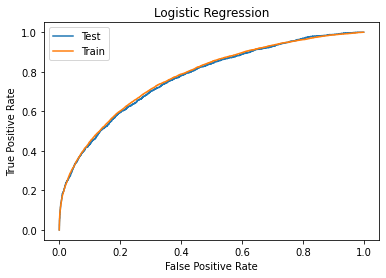

In [5]:
# Plot ROC
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fprT,tprT)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Train'])
plt.title('Logistic Regression')
plt.show()

**Thoughts on Performance**
* Some tuning of the C does affect the curve, but not by much. 
* The AUC will drop but not increase. 
* Try another method during intial exploration phase, like random forest 

**Try Random Forest**

In [6]:
# Start with out of the box RF, and tune after checking performance
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(Xtrain, ytrain)
ypred = clf.predict_proba(Xtest)

In [7]:
fprRF, tprRF, thresholds = roc_curve(ytest, ypred[:,1])
roc_aucRF = auc(fprRF, tprRF)

print('Area under the curve is ', round(roc_aucRF,2))

Area under the curve is  0.82


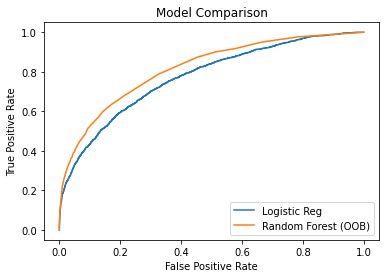

In [8]:
# Plot ROC
plt.plot(fpr,tpr)
plt.plot(fprRF,tprRF)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Reg','Random Forest (OOB)'])
plt.title('Model Comparison')
plt.show()

In [9]:
# Look at decision path for set Random CV search
#clf.decision_path

In [10]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators':np.arange(1,20), #number of trees built before voting,
              'max_features':['auto','sqrt'], #number of features in each tree,
              'max_depth':np.arange(1,20),
              'min_samples_leaf': np.arange(1,10),
              'criterion' : ['gini', 'entropy']}
model = RandomForestClassifier()
model_cv = RandomizedSearchCV(model,param_grid,cv=5)
_ = model_cv.fit(Xtrain,ytrain)

In [11]:
model_cv.best_params_

{'n_estimators': 17,
 'min_samples_leaf': 9,
 'max_features': 'auto',
 'max_depth': 17,
 'criterion': 'entropy'}

In [12]:
ypred = model_cv.predict_proba(Xtest)
fprRFt, tprRFt, thresholds = roc_curve(ytest, ypred[:,1])
roc_aucRFt = auc(fprRFt, tprRFt)

print('Area under the curve is ', round(roc_aucRFt,2))

Area under the curve is  0.82


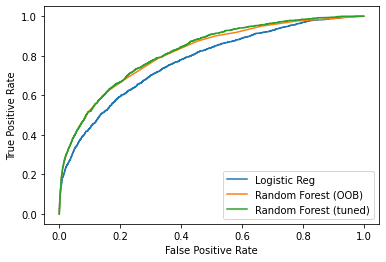

In [13]:
# Plot ROC
plt.plot(fpr,tpr)
plt.plot(fprRF,tprRF)
plt.plot(fprRFt,tprRFt)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Reg','Random Forest (OOB)','Random Forest (tuned)'])
plt.show()

**Random Forest tuning didn't help as much as I though it would. Try Gradient Boosting before comparing feature importances across the 3 algorithms**

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

#param_grid = {'n_estimators':np.array([50,100,200]), #number of trees built before voting,
              #'learning_rate':np.array([0.05, 0.25, 0.75, 1]),
#              'max_features':['sqrt'], #number of features in each tree,
#              'max_depth':np.array([5,10,20]),
#                }

#gb = GradientBoostingClassifier()
#gb_cv= RandomizedSearchCV(gb,param_grid,cv=5)   
#gb_cv.fit(Xtrain, ytrain)

#gb_cv.best_params_ = {n_estimators= 100, max_features= 'sqrt', max_depth= 5}

In [15]:
gb_cv = GradientBoostingClassifier(n_estimators= 100, max_features= 'sqrt', max_depth= 5)
_ = gb_cv.fit(Xtrain,ytrain)

In [16]:
ypred = gb_cv.predict_proba(Xtest)
fprBoost, tprBoost, thresholds = roc_curve(ytest, ypred[:,1])
roc_auc_Boost = auc(fprBoost, tprBoost)

print('Area under the curve is ', round(roc_auc_Boost,2))

Area under the curve is  0.83


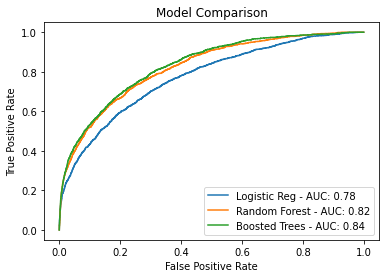

In [17]:
# Plot ROC
plt.plot(fpr,tpr)
plt.plot(fprRFt,tprRFt)
plt.plot(fprBoost,tprBoost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Reg - AUC: 0.78','Random Forest - AUC: 0.82','Boosted Trees - AUC: 0.84'])
plt.title('Model Comparison')
plt.show()

In [18]:
featimp_gb = gb_cv.feature_importances_
featimp_rf = model_cv.best_estimator_.feature_importances_
featimp_lr = logreg.coef_

In [19]:
# Gradient Boosting
featimp_gb_df = pd.DataFrame(zip(featimp_gb,features), columns = ['FeatImp','Features'])
featimp_gb_df.sort_values(by='FeatImp',ascending=False).head()

,FeatImp,Features
7,0.326750,lactate
5,0.157154,apache_3j_diagnosis
8,0.108678,ACR
9,0.080841,h1_temp_min
1,0.059706,age


In [20]:
# Random Forest 
featimp_rf_df = pd.DataFrame(zip(featimp_rf,features), columns = ['FeatImp','Features'])
featimp_rf_df.sort_values(by='FeatImp',ascending=False).head()

,FeatImp,Features
7,0.225799,lactate
8,0.135309,ACR
5,0.127872,apache_3j_diagnosis
6,0.084771,apache_2_diagnosis
1,0.083050,age


In [21]:
# Logistic Regression
featimp_lr_df = pd.DataFrame(zip(featimp_lr.reshape(-1),features), columns = ['FeatImp','Features'])
featimp_lr_df.sort_values(by='FeatImp',ascending=False).head()

,FeatImp,Features
7,6.633384e-06,lactate
1,2.208119e-06,age
40,2.061232e-06,apache_3j_bodysystem_Sepsis
18,1.557132e-06,icu_admit_source_Floor
26,7.805868e-07,icu_type_MICU


## Model/Error Analysis

* Use the Random Forest and look at train/test error with increasing training size
    *Random Forest becuase it behaved equally well with Gradient Boosting (sometimes just under) and it is quick to train
* Follow [Error analysis from Andrew Ng](http://cs229.stanford.edu/materials/ML-advice.pdf)



In [22]:
Xtrain.shape

(73260, 42)

In [23]:
from sklearn.metrics import mean_squared_error as mse
N = [1000, 5000, 10000, 20000,30000, 40000, 50000, 60000, 70000,73260]

In [24]:
# Choose the best parameters from RandomForestClassifier
model_rf = RandomForestClassifier(
            n_estimators= 16,
            min_samples_leaf =  3,
            max_features = 'auto',
            max_depth = 16,
            criterion = 'gini')

In [25]:
test_error = []
train_error = []
test_roc = []
train_roc = []

for m in N:
    model_rf.fit(Xtrain[:m], ytrain[:m])
    
    # Get error stats
    ypred = model_rf.predict(Xtest)
    test_error.append(mse(ytest, ypred))
    ypred = model_rf.predict(Xtrain[:m])
    train_error.append(mse(ytrain[:m], ypred))
        
    # Look at AUC performance
    ypred = model_rf.predict_proba(Xtest)
    fprRF, tprRF, thresholds = roc_curve(ytest, ypred[:,1])
    test_roc.append(auc(fprRF, tprRF))
    
    ypred = model_rf.predict_proba(Xtrain[:m])
    fprRF, tprRF, thresholds = roc_curve(ytrain[:m], ypred[:,1])
    train_roc.append(auc(fprRF, tprRF))

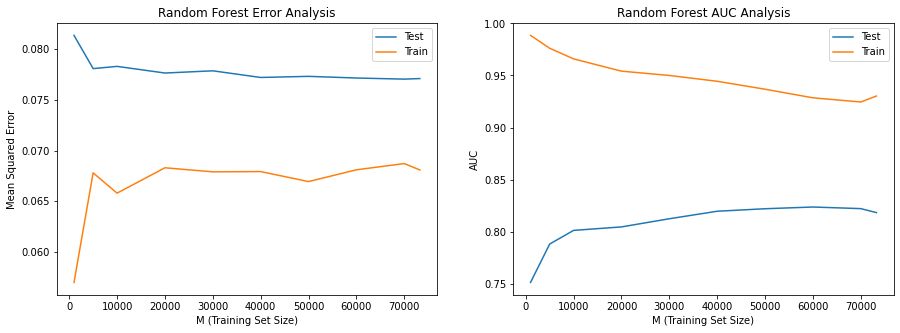

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

ax[0].plot(N,test_error)
ax[0].plot(N,train_error)
ax[0].legend(['Test','Train'])
ax[0].set(xlabel ='M (Training Set Size)')
ax[0].set(ylabel = 'Mean Squared Error')
ax[0].set_title('Random Forest Error Analysis')

ax[1].plot(N,test_roc)
ax[1].plot(N,train_roc)
ax[1].legend(['Test','Train'])
ax[1].set(xlabel ='M (Training Set Size)')
ax[1].set(ylabel = 'AUC')
ax[1].set_title('Random Forest AUC Analysis')

plt.show()